初始化spark环境

In [1]:
import findspark
findspark.init()

from pyspark.ml import Pipeline
from pyspark.sql import SparkSession 
import pyspark.sql.functions as F
spark = SparkSession.builder.master('local').getOrCreate()

# 加载 utils.py 中的自定义方法
from utils import *


# Feature Struct

* DataFrame操作 https://blog.csdn.net/sinat_26917383/article/details/80500349 
* DataFrame基础 https://zhuanlan.zhihu.com/p/34901683
* 处理稀疏特征 http://www.4o4notfound.org/index.php/archives/123/
* 用户自定义函数 https://stackoverflow.com/questions/29109916/updating-a-dataframe-column-in-spark

设置schema

In [2]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType

In [3]:
schema = StructType([
StructField("duration",IntegerType(),False),
StructField("protocol_type",StringType(),False),
StructField("service",StringType(),False),
StructField("flag",StringType(),False),
StructField("src_bytes",IntegerType(),False),
StructField("dst_bytes",IntegerType(),False),
StructField("land",IntegerType(),False),
StructField("wrong_fragment",IntegerType(),False),
StructField("urgent",IntegerType(),False),
StructField("hot",IntegerType(),False),
StructField("num_failed_logins",IntegerType(),False),
StructField("logged_in",IntegerType(),False),
StructField("num_compromised",IntegerType(),False),
StructField("root_shell",IntegerType(),False),
StructField("su_attempted",IntegerType(),False),
StructField("num_root",IntegerType(),False),
StructField("num_file_creations",IntegerType(),False),
StructField("num_shells",IntegerType(),False),
StructField("num_access_files",IntegerType(),False),
StructField("num_outbound_cmds",IntegerType(),False),
StructField("is_host_login",IntegerType(),False),
StructField("is_guest_login",IntegerType(),False),
StructField("count",IntegerType(),False),
StructField("srv_count",IntegerType(),False),
StructField("serror_rate",FloatType(),False),
StructField("srv_serror_rate",FloatType(),False),
StructField("rerror_rate",FloatType(),False),
StructField("srv_rerror_rate",FloatType(),False),
StructField("same_srv_rate",FloatType(),False),
StructField("diff_srv_rate",FloatType(),False),
StructField("srv_diff_host_rate",FloatType(),False),
StructField("dst_host_count",IntegerType(),False),
StructField("dst_host_srv_count",IntegerType(),False),
StructField("dst_host_same_srv_rate",FloatType(),False),
StructField("dst_host_diff_srv_rate",FloatType(),False),
StructField("dst_host_same_src_port_rate",FloatType(),False),
StructField("dst_host_srv_diff_host_rate",FloatType(),False),
StructField("dst_host_serror_rate",FloatType(),False),
StructField("dst_host_srv_serror_rate",FloatType(),False),
StructField("dst_host_rerror_rate",FloatType(),False),
StructField("dst_host_srv_rerror_rate",FloatType(),False),
StructField("label",StringType(),False)
])

从本地读取数据

In [4]:
# 从csv中读取
dataset = spark.read.csv('Data/kddcup.data_10_percent.gz', header=None,schema=schema)
dataset.printSchema()

root
 |-- duration: integer (nullable = true)
 |-- protocol_type: string (nullable = true)
 |-- service: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- src_bytes: integer (nullable = true)
 |-- dst_bytes: integer (nullable = true)
 |-- land: integer (nullable = true)
 |-- wrong_fragment: integer (nullable = true)
 |-- urgent: integer (nullable = true)
 |-- hot: integer (nullable = true)
 |-- num_failed_logins: integer (nullable = true)
 |-- logged_in: integer (nullable = true)
 |-- num_compromised: integer (nullable = true)
 |-- root_shell: integer (nullable = true)
 |-- su_attempted: integer (nullable = true)
 |-- num_root: integer (nullable = true)
 |-- num_file_creations: integer (nullable = true)
 |-- num_shells: integer (nullable = true)
 |-- num_access_files: integer (nullable = true)
 |-- num_outbound_cmds: integer (nullable = true)
 |-- is_host_login: integer (nullable = true)
 |-- is_guest_login: integer (nullable = true)
 |-- count: integer (nullable = true

## Attack type division

40 attack types, mapped into five categories:

* 0 NORMAL
* 1 PROBE
* 2 DOS
* 3 U2R
* 4 R2L

In [5]:
attack2majorindex = {
        'normal.': 0,
        'ipsweep.': 1,
        'mscan.': 1,
        'nmap.': 1,
        'portsweep.': 1,
        'saint.': 1,
        'satan.': 1,
        'apache2.': 2,
        'back.': 2,
        'mailbomb.': 2,
        'neptune.': 2,
        'pod.': 2,
        'land.': 2,
        'processtable.': 2,
        'smurf.': 2,
        'teardrop.': 2,
        'udpstorm.': 2,
        'buffer_overflow.': 3,
        'loadmodule.': 3,
        'perl.': 3,
        'ps.': 3,
        'rootkit.': 3,
        'sqlattack.': 3,
        'xterm.': 3,
        'ftp_write.': 4,
        'guess_passwd.': 4,
        'httptunnel.': 3,  # disputation resolved
        'imap.': 4,
        'multihop.': 4,  # disputation resolved
        'named.': 4,
        'phf.': 4,
        'sendmail.': 4,
        'snmpgetattack.': 4,
        'snmpguess.': 4,
        'worm.': 4,
        'xlock.': 4,
        'xsnoop.': 4,
        'spy.': 4,
        'warezclient.': 4,
        'warezmaster.': 4  # disputation resolved
}
index2major ={
    0:'NORMAL',
    1:'PROBE',
    2:'DOS',
    3:'U2R',
    4:'R2L'
}

In [6]:
def attack2majorindex(label):
    '''
    :index: in 40 attack types
    :return: attack_type to index in [0,1,2,3,4]
    '''
    return specific[label]

In [7]:
def majorindex2string(index):
    '''
    :index: in [0,1,2,3,4]
    :return: String: NORMAL,PROBE,DOS,U2R,R2L
    '''
    return index2major[index]

In [8]:
#from utils import mapper_attack2majorindex

function_attack2majorindex = F.UserDefinedFunction(attack2majorindex,IntegerType())

In [9]:
dataset = dataset.select(
    *[function_attack2majorindex(column).alias('label') if column == 'label' else column for column in dataset.columns]
)
dataset.select('label').show(5)

+-----+
|label|
+-----+
|    0|
|    0|
|    0|
|    0|
|    0|
+-----+
only showing top 5 rows



分类编码 Pipeline 

In [10]:
from pyspark.ml.feature import StringIndexer

fearture_string = ['protocol_type', 'service', 'flag']
pipeline_stringindex = Pipeline(stages=[
    StringIndexer(inputCol=c, outputCol='{}_index'.format(c),handleInvalid='keep')
    for c in fearture_string
])

pipeline_stringindex_fitted = pipeline_stringindex.fit(dataset=dataset)

In [11]:
dataset_indexed = pipeline_stringindex_fitted.transform(dataset=dataset)

In [12]:
dataset_indexed.select('protocol_type','protocol_type_index','service','service_index','flag','flag_index','label').show(5)

+-------------+-------------------+-------+-------------+----+----------+-----+
|protocol_type|protocol_type_index|service|service_index|flag|flag_index|label|
+-------------+-------------------+-------+-------------+----+----------+-----+
|          tcp|                1.0|   http|          2.0|  SF|       0.0|    0|
|          tcp|                1.0|   http|          2.0|  SF|       0.0|    0|
|          tcp|                1.0|   http|          2.0|  SF|       0.0|    0|
|          tcp|                1.0|   http|          2.0|  SF|       0.0|    0|
|          tcp|                1.0|   http|          2.0|  SF|       0.0|    0|
+-------------+-------------------+-------+-------------+----+----------+-----+
only showing top 5 rows



In [13]:
# 存储 pipeline
pipeline_stringindex_fitted.write().overwrite().save('SparkRF/pipeline_stringindex_fitted')

In [14]:
# 加载 pipeline
from pyspark.ml import PipelineModel
pipeline_stringindex_fitted = PipelineModel.load('SparkRF/pipeline_stringindex_fitted')

# Decision Tree

* maxBin取值 https://stackoverflow.com/questions/38767786/spark-mllib-2-0-categorical-features-in-pipeline

In [15]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler
from time import time

构造训练集 [features][label]

In [16]:
def featuresToVec(dataset_indexed):
    # 构造特征向量
    features=[dataset_indexed.columns[0]]+dataset_indexed.columns[4:]
    features.remove('label')
    feature_vec = VectorAssembler(inputCols=features,outputCol='feature_vec').transform(dataset_indexed)
    # 组合数据集： 特征向量，标签
    return feature_vec.select('feature_vec','label')

In [17]:
dataset_indexed = featuresToVec(dataset_indexed)

In [18]:
# 划分训练集，测试集
train_set,test_set = dataset_indexed.randomSplit([0.8,0.2])

In [19]:
dt = DecisionTreeClassifier(
    featuresCol='feature_vec', # 特征
    labelCol='label', #标签
    impurity='gini', # 考虑到样本分布和计算效率
    maxDepth=5, # 最大深度
    maxBins=72, # 根据样本训练集确定
    seed=5, 
)

In [20]:
# 训练模型
t0 = time()
dt_model = dt.fit(train_set)
tt = time() -t0
print("Trains in {} seconds".format(round(tt,3)))

Trains in 19.38 seconds


In [23]:
# 保存训练好的机器学习模型
dt_model.write().overwrite().save('SparkDT/dt_SparkDT')

In [24]:
# 加载本地机器学习模型
from pyspark.ml.classification import DecisionTreeClassificationModel
dt_model=DecisionTreeClassificationModel.load('SparkDT/dt_SparkDT')

In [26]:
# 预测
t0 = time()
test_result = dt_model.transform(test_set)
tt = time() -t0
print("Perdict in {} seconds".format(round(tt,3)))

Perdict in 0.036 seconds


# 评价

#### 交叉验证打分

In [27]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [28]:
evaluator = MulticlassClassificationEvaluator(labelCol='label',predictionCol='prediction')
score={}
# for metric in ['accuracy','f1','weightedPrecision','weightedRecall']:
for metric in ['accuracy','f1']:
    t0 = time()
    score[metric] = evaluator.evaluate(dataset=test_result,params={evaluator.metricName:metric})
    tt = time() -t0
    print("%-*s %f \t %f seconds"%( 30 , metric, score[metric], round(tt,3)))
    

accuracy                       0.994306 	 3.473000 seconds
f1                             0.993089 	 2.986000 seconds


### 验证集打分

数据导入与处理

In [29]:
corrected = spark.read.csv('Data/corrected.gz', header=None,schema=schema)

# 攻击类型分类
corrected = corrected.select(
    *[function_attack2majorindex(column).alias('label') if column == 'label' else column for column in corrected.columns]
)
# 分类编码
corrected_indexed = pipeline_stringindex_fitted.transform(corrected)

# 划分 features vector 和 label
corrected_set = featuresToVec(corrected_indexed)

预测

In [30]:
t0 = time()
corrected_result = dt_model.transform(corrected_set)
tt = time() -t0
print("Perdict in {} seconds".format(round(tt,3)))

Perdict in 0.033 seconds


评价

In [31]:
evaluator = MulticlassClassificationEvaluator(labelCol='label',predictionCol='prediction')
score_corrected={}
# for metric in ['accuracy','weightedPrecision','weightedRecall','f1']:
for metric in ['accuracy','f1']:
    t0 = time()
    score_corrected[metric] = evaluator.evaluate(dataset=corrected_result,params={evaluator.metricName:metric})
    tt = time() -t0
    print("%-*s %f \t %f seconds"%( 30 , metric, score_corrected[metric], round(tt,3)))

accuracy                       0.920535 	 1.782000 seconds
f1                             0.899846 	 1.633000 seconds


# 混淆矩阵

In [32]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [33]:
# convert DF column to list
def getListFromDF(df,colname):
    tmp = df.select(colname).toPandas()
    return tmp.iloc[:,0].values

In [34]:
# 直接根据测试结果DF 绘制混淆矩阵,并输出评分
def drawFromDF(dataset):
    true = getListFromDF(dataset,'label')
    pred = getListFromDF(dataset,'prediction')
    cm,plt = drawConfusionMatrix(true,pred,[0,1,2,3,4])
    plt.show()
    preAndRec(cm=cm,labels=[0,1,2,3,4])
    return cm,true,pred

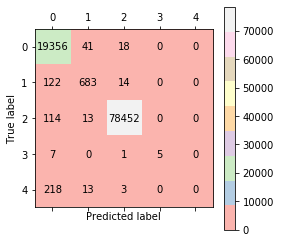

------------------------------
Precision:
0 : 	 0.976737
1 : 	 0.910667
2 : 	 0.999541
3 : 	 1.000000
4 : 	 nan

Recall:
0 : 	 0.996961
1 : 	 0.833944
2 : 	 0.998384
3 : 	 0.384615
4 : 	 0.000000
------------------------------


/Users/lila/Downloads/KDDCUP99_PySpark/utils.py:174: RuntimeWarning: invalid value encountered in long_scalars
  result[x]= tp/s if s is not 0 else 0


In [35]:
test_cm,test_true,test_pred = drawFromDF(dataset=test_result)

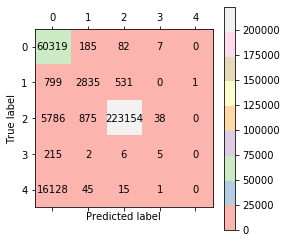

------------------------------
Precision:
0 : 	 0.724579
1 : 	 0.719178
2 : 	 0.997167
3 : 	 0.098039
4 : 	 0.000000

Recall:
0 : 	 0.995478
1 : 	 0.680509
2 : 	 0.970855
3 : 	 0.021930
4 : 	 0.000000
------------------------------


In [36]:
corrected_cm,corrected_true,corrected_pred = drawFromDF(dataset=corrected_result)